## Training with multiple GPUs

In [1]:
import time
import tensorflow as tf
from collections import OrderedDict
from lossycomp.dataLoader import DataGenerator, data_preprocessing, split_data
from lossycomp.utils import check_gpu, Autoencoder

In [2]:
# Check number of gpus
check_gpu()
# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy() #tf.distribute.experimental.MultiWorkerMirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


In [3]:
# Open a strategy scope.
with strategy.scope():
    model = Autoencoder((12, 40, 40, 1), [10, 20], [4,4], [2,2])

In [4]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12, 40, 40, 1)]   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 6, 20, 20, 10)     650       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 3, 10, 10, 20)     12820     
_________________________________________________________________
conv3d_transpose (Conv3DTran (None, 6, 20, 20, 10)     12810     
_________________________________________________________________
conv3d_transpose_1 (Conv3DTr (None, 12, 40, 40, 1)     641       
Total params: 26,921
Trainable params: 26,921
Non-trainable params: 0
_________________________________________________________________


In [5]:
import dask
dask.config.set(**{'array.slicing.split_large_chunks': False})

file = '/lsdf/kit/scc/projects/abcde/1979/*/ERA5.pl.temperature.nc'
region = "europe"
var = OrderedDict({'t': 1000})

z, mean, std = data_preprocessing(file, var, region)

train, test = split_data(z, 0.70)

leads = dict(time = 12, longitude=40, latitude=40, level=1)

dg_train = DataGenerator(train, 100000, leads, batch_size=100, load=True, mean= mean, std=std) 
dg_test = DataGenerator(test, 20000, leads, batch_size=100, load=True, mean= mean, std=std)

Loading data into RAM
Loading data into RAM


In [6]:
start = time.time()
history = model.fit(dg_train, validation_data = dg_test, epochs=40, use_multiprocessing = True, workers = 4)
end = time.time()

Epoch 1/40
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
 995/1000 [============================>.] - ETA: 0s - loss: 0.0504WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For

In [7]:
print(end - start)

978.1129293441772


Increasing the number of workers and enabling multiprocessing makes the training a 2 times faster. There shouldnt be any deadlocks since im not writing any data... just reading.

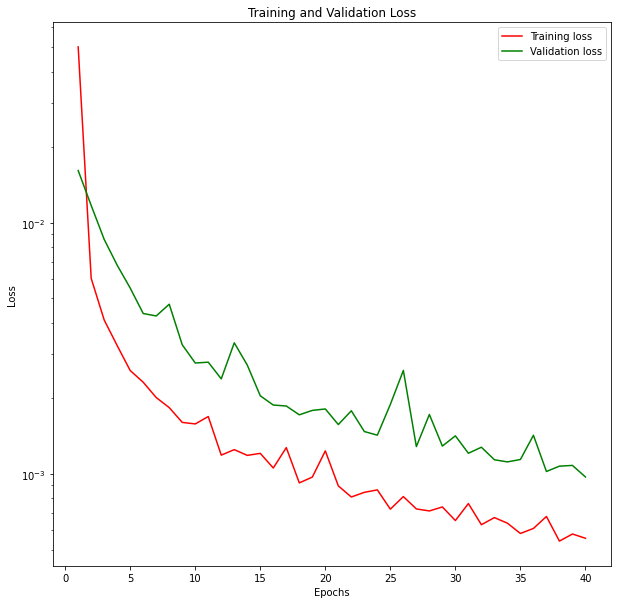

In [9]:
from lossycomp.plots import plot_loss
plot_loss(history, 'Training and Validation Loss', 'Epochs', 'Loss')